In this notebook we will use the nn class **Sequential** to model a CNN

We will use the single target network

# Import

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import KFold

from tqdm import tqdm

import load_script
from params import *
from custom_layers import *
from training import *

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading the dataset

In [19]:
train_dataset,train_target=load_script.load_dataset_1000hz(train=True)

In [20]:
test_dataset,test_target=load_script.load_dataset_1000hz(train=False)

In [21]:
train_dataset,train_target=load_script.load_dataset(train=True)

In [22]:
test_dataset,test_target=load_script.load_dataset(train=False)

# Normalization

In [23]:
train_dataset.shape

torch.Size([316, 28, 50])

In [24]:
test_dataset.shape

torch.Size([100, 28, 50])

In [25]:
mean=train_dataset.mean(0).view(1,28,50)
std=train_dataset.std(0).view(1,28,50)

In [26]:
train_dataset=(train_dataset-mean)/std
test_dataset=(test_dataset-mean)/std

# Defining the network

### Simple Network

In [27]:
class ThreeLayers(nn.Module):
    
    num_my_conv_layers=3
    num_linear_layers=2
    
    def __init__(self,params):
        super(ThreeLayers,self).__init__()
        
        self.params=params
        
        layers=[]
        for i in range(self.num_my_conv_layers): 
            layers+=MyConv1D(*self.params[i]).layers
        
        layers.append(Flatten())
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.6))
        
        layers.append(nn.Linear(*self.params[self.num_my_conv_layers+1]))
        
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x

In [37]:
class FullConnect(nn.Module):
    num_my_conv_layers=0
    num_linear_layers=4
    
    def __init__(self,params):
        super(FullConnect,self).__init__()
        self.dropouts=[0.8,0.8,0.8,0]
        self.params=params
        layers=[]
        layers.append(Flatten())
        for i in range(self.num_linear_layers):
            layers.append(nn.Linear(*self.params[self.num_my_conv_layers+i]))
            layers.append(nn.BatchNorm1d(self.params[self.num_my_conv_layers+i][1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(self.dropouts[i]))
        
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x
        

In [35]:
class FullConv(nn.Module):
    num_my_conv_layers=4
    num_linear_layers=0
    def __init__(self,params):
        super(FullConv,self).__init__()
        
        self.params=params
        layers=[]
        for i in range(self.num_my_conv_layers):
            layers+=MyConv1D(*self.params[i]).layers
        
        layers.append(Flatten())
        self.sequential=nn.Sequential(*layers)
        
    def forward(self,x):
        x=self.sequential(x)
        
        return x

# Training

## Full Convolutional training

In [31]:
cv=CrossValidation(k=2,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target)

net_type=FullConv
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(conv_filters=[28,14,7,2],conv_kernels=[5,9,11,20],dropout_rate=[0.8,0.8,0,0],\
                             stride=1,dilation=[3,1,1,1])
#network_params=NetworkParams(linear_filters=[244,2],dropout_rate=0.8,dilation=[5,1,1])
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=500,mini_batch_size=2*79)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,\
              optimizer_params=optimizer_params,train_params=train_params)

cv(params)

  1%|          | 3/500 [00:00<00:19, 26.08it/s]

FullConv(
  (sequential): Sequential(
    (0): Conv1d(28, 28, kernel_size=(5,), stride=(1,), dilation=(3,))
    (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.8)
    (4): Conv1d(28, 14, kernel_size=(9,), stride=(1,))
    (5): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU()
    (7): Dropout(p=0.8)
    (8): Conv1d(14, 7, kernel_size=(11,), stride=(1,))
    (9): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU()
    (11): Dropout(p=0)
    (12): Conv1d(7, 2, kernel_size=(20,), stride=(1,))
    (13): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True)
    (14): ReLU()
    (15): Dropout(p=0)
    (16): Flatten(
    )
  )
)


 22%|██▏       | 108/500 [00:03<00:11, 32.87it/s]


KeyboardInterrupt: 

# Train full connnected

  1%|          | 7/1000 [00:00<00:15, 64.51it/s]

FullConnect(
  (sequential): Sequential(
    (0): Flatten(
    )
    (1): Linear(in_features=1400, out_features=500, bias=True)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
    (3): ReLU()
    (4): Dropout(p=0.8)
    (5): Linear(in_features=500, out_features=100, bias=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
    (7): ReLU()
    (8): Dropout(p=0.8)
    (9): Linear(in_features=100, out_features=50, bias=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU()
    (12): Dropout(p=0.8)
    (13): Linear(in_features=50, out_features=2, bias=True)
    (14): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True)
    (15): ReLU()
    (16): Dropout(p=0)
  )
)


100%|██████████| 1000/1000 [00:15<00:00, 66.58it/s]


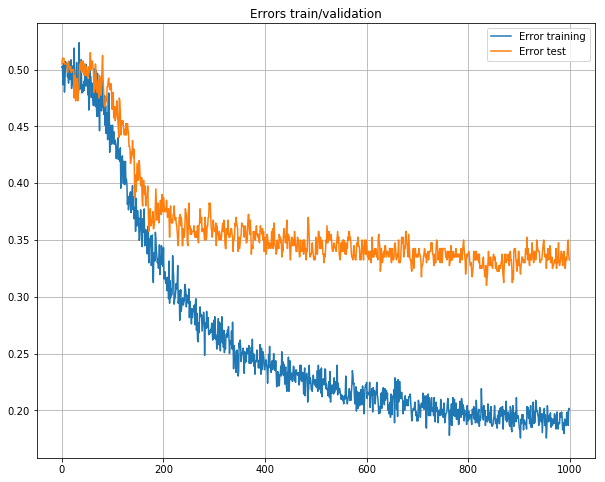

Performance train: 0.194575949367
Performance test: 0.33342


In [38]:
cv=CrossValidation(k=2,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target,cuda=True)

net_type=FullConnect
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
#network_params=NetworkParams(conv_filters=[28,14,7,2],conv_kernels=[5,9,11,20],dropout_rate=[0.6,0.6,0,0],\
 #                            stride=1,dilation=[3,1,1,1])
network_params=NetworkParams(linear_filters=[500,100,50,2],conv1D=False)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=1000,mini_batch_size=79)

params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,\
              optimizer_params=optimizer_params,train_params=train_params,cuda=True)

cv(params, cross_validation=False, repetitions=1, repetitions_test=4)

In [ ]:
? nn.Conv1d

In [ ]:
list_diego=[1,2,3]
list_rosa=[4,5,6]
fiori=zip(list_diego,list_rosa)
for i in fiori: print(i)

In [ ]:
? zip

In [ ]:
? nn.Conv2d